##### <p> Samuel Wolfe <br> August 1, 2023 <br> MSBA 206 <br> DMBA SBA Case 1</p>

In [587]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import requests
import io
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import LassoCV, Lasso, Ridge
from sklearn.feature_selection import SelectFromModel
from dmba import regressionSummary, classificationSummary, liftChart, gainsChart
from sklearn.pipeline import make_pipeline

In [588]:
def readFile(url):
    download = requests.get(url).content
    # Reading the downloaded content and turning it into a pandas dataframe
    df = pd.read_csv(io.StringIO(download.decode('utf-8')))
    return df
def statslist(df):
    dfStats = pd.DataFrame({'Mean' : df.mean(numeric_only=True),
            'SD' : df.std(numeric_only=True),
            'Min' : df.min(),
            'Max' : df.max(),
            'Median' : df.median(numeric_only=True),
            })
    return dfStats
def categorize(df):
    for x in df:
        df[x] = df[x].astype('category')
    return df
def samLasso(X,y,predictors,z):
    clf = LassoCV().fit(X, y)
    importance = np.abs(clf.coef_)
    idx_third = importance.argsort()[-3]
    threshold = importance[idx_third] + 0.01

    idx_features = (-importance).argsort()[:z]
    name_features = np.array(predictors)[idx_features]
    print('Selected features: {}'.format(name_features))
def samDum(df,outcome):
    X = pd.get_dummies(df.drop(columns=outcome), drop_first=True)
    y = df[outcome]
    predictors = X.columns.to_list()
    return X,y,predictors

#### Loading data

In [589]:
dfSBA = readFile("https://raw.githubusercontent.com/wolfesamk/MSBA-206/main/dmba/SBAcase.11.13.17.csv")
#The values below fit one of the following categories
# -Duplicate
# -not needed
# -cannot be used in future predictions (Dates of loan given and defaulted, specific historical markers, etc.)
dropCol = ['Name','State','ApprovalDate','Zip','Selected','NewExist','MIS_Status','BalanceGross','ChgOffDate',
           'ApprovalFY','DisbursementDate','ChgOffPrinGr','SBA_Appv','GrAppv','Recession','daysterm','xx']
outcome = 'Default'

#### Doing some correlation to see what predictors this recommends.

In [590]:
cutoff = 0.5
dfSBACorr = dfSBA.drop(columns=dropCol).drop(columns='LoanNr_ChkDgt').corr(numeric_only=True)
dfSBACorrPair = dfSBACorr.unstack().sort_values(ascending=False).drop_duplicates().dropna()
dfSBACorrPairMost = dfSBACorrPair[dfSBACorrPair != 1.0]
print("Most correlated\n", dfSBACorrPairMost)

Most correlated
 RealEstate         Term          0.939372
Portion            Term          0.648748
                   RealEstate    0.643883
DisbursementGross  Term          0.603073
                   RealEstate    0.585861
                                   ...   
NAICS              UrbanRural   -0.268831
DisbursementGross  Default      -0.271244
Portion            Default      -0.367511
RealEstate         Default      -0.369024
Default            Term         -0.480625
Length: 66, dtype: float64


In [591]:
cutoff = 0.12
dfSBACorrReduced = (dfSBACorr.abs() > cutoff).sum() - 1
print("Correlation\n", dfSBACorrReduced.sort_values(ascending=False).head(17))

Correlation
 Portion              9
Term                 7
CreateJob            7
DisbursementGross    7
RealEstate           7
NoEmp                6
Default              6
UrbanRural           4
NAICS                3
RetainedJob          3
FranchiseCode        2
New                  1
dtype: int64


In [592]:
dfSBACorrReduced = dfSBACorrReduced.to_frame()
dfSBACorrReduced['Correlations'] = dfSBACorrReduced[0]
dfSBACorrReduced = dfSBACorrReduced.drop(columns=0).T
dfSBACorrReduced = dfSBACorrReduced.loc[:, (dfSBACorrReduced != 0).any(axis=0)]
Corrpredictors = dfSBACorrReduced.columns.to_list()

<Axes: >

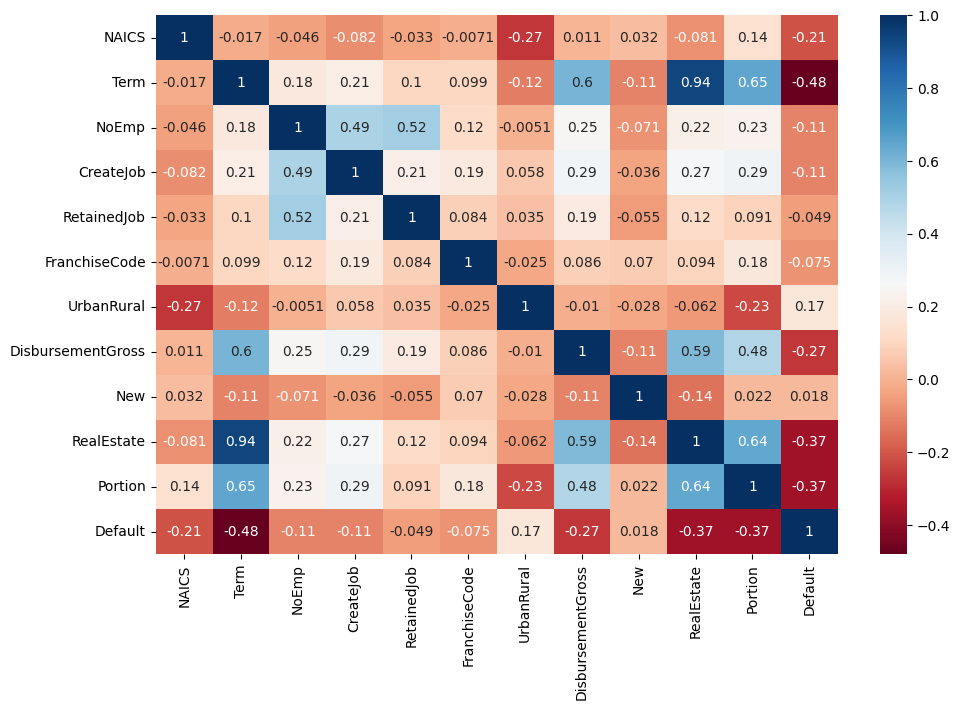

In [593]:
dfSBACorr = dfSBA[Corrpredictors].corr(numeric_only=True)
fig, ax = plt.subplots()
fig.set_size_inches(11,7)
sns.heatmap(dfSBACorr, annot=True, xticklabels=dfSBACorr.columns, yticklabels=dfSBACorr.columns, cmap='RdBu')

#### Using Correlation we find that our predictors should be 'NAICS', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural',  DisbursementGross', 'New', 'RealEstate', 'Portion', 'Default'.

#### Lasso analysis to find the best predictors.

In [594]:
dropCol2 = ['LoanNr_ChkDgt']
dfSBA_finder = dfSBA.drop(columns=dropCol).dropna()
dfSBA_finder = dfSBA_finder.drop(columns=dropCol2)
X,y,predictors = samDum(dfSBA_finder, outcome)
samLasso(X,y,predictors,10)

Selected features: ['NAICS' 'FranchiseCode' 'DisbursementGross' 'City_TEHACHAPI'
 'City_TEMECULA' 'City_TEMPLE CITY' 'City_TEMPLE CITY (RUDELL)'
 'City_THOUSAND OAKS' 'City_TOLUCA LAKE' 'City_TOPANGA']


#### As you can see above, it wants us to use Cities after NAICS. While that may be useful long term lets see if there are any other variables we can use.

In [595]:
dropCol2 = ['LoanNr_ChkDgt','City']
dfSBA_finder = dfSBA.drop(columns=dropCol).dropna()
dfSBA_finder = dfSBA_finder.drop(columns=dropCol2)
outcome = 'Default'
X,y,predictors = samDum(dfSBA_finder, outcome)
samLasso(X,y,predictors,10)

Selected features: ['NAICS' 'FranchiseCode' 'DisbursementGross' 'Bank_PFF BANK & TRUST'
 'Bank_PLAZA BANK' 'Bank_PNC BANK, NATIONAL ASSOCIATION'
 'Bank_PREMIER VALLEY BANK' 'Bank_RABOBANK, NATIONAL ASSOCIATION'
 'Bank_READYCAP LENDING, LLC' 'Bank_REDDING BANK OF COMMERCE']


#### Same as the previous time, it wants us to use Bank names. Useful, but lets remove it as well for now.

In [596]:
dropCol2 = ['LoanNr_ChkDgt','City','Bank']
dfSBA_finder = dfSBA.drop(columns=dropCol).dropna()
dfSBA_finder = dfSBA_finder.drop(columns=dropCol2)
outcome = 'Default'
X,y,predictors = samDum(dfSBA_finder, outcome)
samLasso(X,y,predictors,10)

Selected features: ['NAICS' 'FranchiseCode' 'DisbursementGross' 'BankState_NY' 'BankState_OH'
 'BankState_OR' 'BankState_RI' 'BankState_SC' 'BankState_SD'
 'BankState_TX']


#### BankState will get similar treatment.

In [597]:
dropCol2 = ['LoanNr_ChkDgt','City','Bank','BankState']
dfSBA_finder = dfSBA.drop(columns=dropCol).dropna()
dfSBA_finder = dfSBA_finder.drop(columns=dropCol2)
outcome = 'Default'
X,y,predictors = samDum(dfSBA_finder, outcome)
samLasso(X,y,predictors,26)
Lasso_predictors = predictors

Selected features: ['NAICS' 'FranchiseCode' 'DisbursementGross' 'LowDoc_N' 'LowDoc_A'
 'RevLineCr_Y' 'RevLineCr_T' 'RevLineCr_N' 'Portion' 'New' 'LowDoc_S'
 'UrbanRural' 'RetainedJob' 'CreateJob' 'NoEmp' 'Term' 'RealEstate'
 'LowDoc_Y']


#### Here we go, I believe this list of variables is starting to look good. Below I will make our predictors list.

In [598]:
predictors = ['NAICS', 'FranchiseCode', 'DisbursementGross', 'LowDoc_N', 'LowDoc_A', 'RevLineCr_Y', 'RevLineCr_T', 'RevLineCr_N',
              'Portion', 'New', 'LowDoc_S', 'UrbanRural', 'RetainedJob', 'CreateJob', 'NoEmp', 'Term', 'RealEstate', 'LowDoc_Y']

In [599]:
X = pd.get_dummies(dfSBA, drop_first=True)
X = X[Corrpredictors]
X['Default'] = dfSBA[outcome]


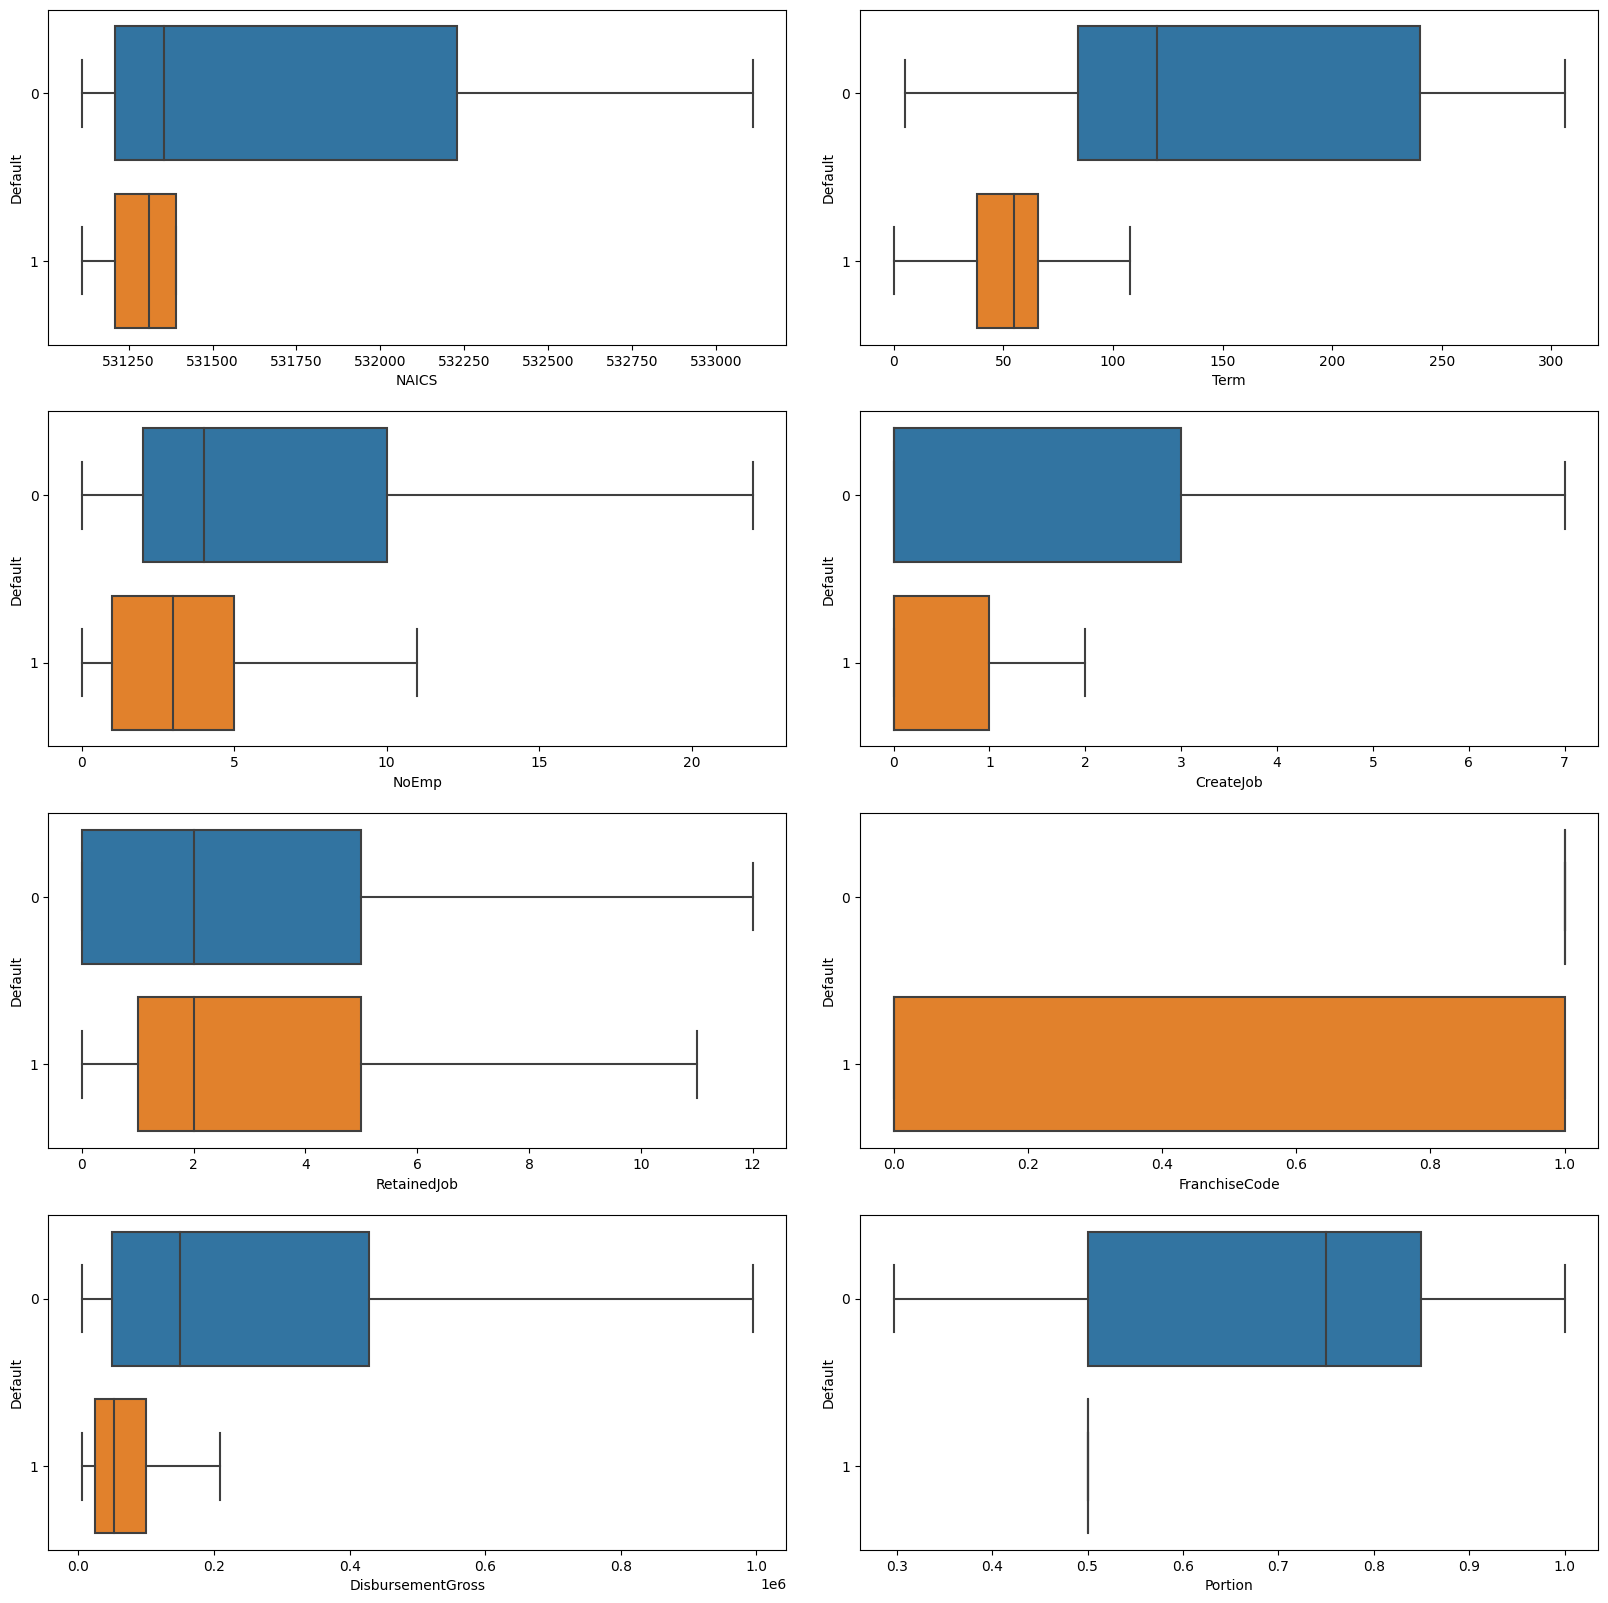

In [600]:
colact = 2
rowact = 4
fig, ax = plt.subplots(rowact, colact, figsize=(20, 20))
plt.subplots_adjust(wspace=0.1)
rowbase=0
colbase=0
listdf = X.drop(columns=['UrbanRural','RealEstate','New','Default']).columns
lendf = 0
while rowbase < rowact:
    while colbase < colact:
        sns.boxplot(data=X, ax=ax[rowbase,colbase], y=outcome, x=X[listdf[lendf]],orient='h',showfliers = False)
        ax[rowbase,colbase].set_ylabel(outcome)
        colbase = colbase + 1
        lendf = lendf + 1
        if lendf > 26:
            break
    rowbase = rowbase + 1
    colbase = 0
plt.show()

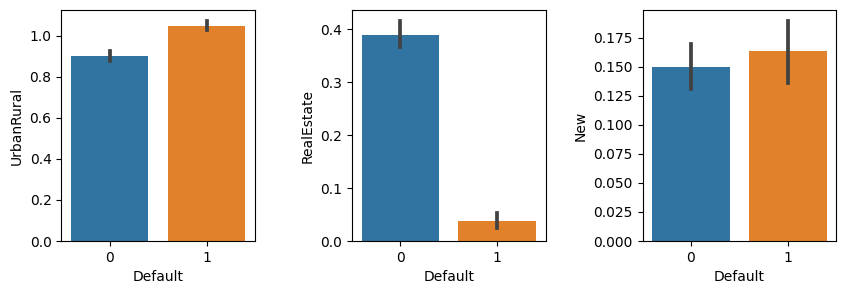

In [601]:
colact = 3
rowact = 1
fig, ax = plt.subplots(rowact, colact, figsize=(10, 3))
plt.subplots_adjust(wspace=0.5)
rowbase=0
colbase=0
listdf = X[['UrbanRural','RealEstate','New']].columns
lendf = 0
while rowbase < rowact:
    while colbase < colact:
        sns.barplot(data=X, x=outcome,y=X[listdf[lendf]],ax=ax[colbase])
        ax[colbase].set_xlabel(outcome)
        colbase = colbase + 1
        lendf = lendf + 1
        if lendf > 2:
            break
    rowbase = rowbase + 1
    colbase = 0
plt.show()

#### Correlation:'NAICS', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural',  DisbursementGross', 'New', 'RealEstate', 'Portion', 'Default'.
#### Lasso: 'NAICS', 'FranchiseCode', 'DisbursementGross', 'LowDoc_N', 'LowDoc_A', 'RevLineCr_Y', 'RevLineCr_T', 'RevLineCr_N', 'Portion', 'New', 'LowDoc_S', 'UrbanRural', 'RetainedJob', 'CreateJob', 'NoEmp', 'Term', 'RealEstate', 'LowDoc_Y'.
#### Will be using the Lasso Variables for my predictions.
#### I believe I will Bin NoEmp, CreateJob, RetainedJob into binaries based on their general largest groups vs smaller groups.

#### KNN for prediction.

In [602]:
dropCol = ['Name','State','ApprovalDate','Zip','NewExist','MIS_Status','BalanceGross','ChgOffDate',
           'ApprovalFY','DisbursementDate','ChgOffPrinGr','SBA_Appv','GrAppv','Recession','daysterm','xx']

In [603]:
dfSBA_DumDum = pd.get_dummies(dfSBA.drop(columns=dropCol), drop_first=False)
train_SBA = dfSBA_DumDum[dfSBA_DumDum.Selected == 1]
hold_SBA = dfSBA_DumDum[dfSBA_DumDum.Selected == 0]
valid_SBA, test_SBA = train_test_split(hold_SBA, test_size=0.5, random_state=1)
predictors = train_SBA.columns.to_list()

In [604]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_SBA[predictors])
#scaler.transform(train_df[predictors])
# Transform the predictors of training, validation and newCustomer
train_X = scaler.transform(train_SBA[predictors])
train_y = train_SBA[outcome]
valid_X = scaler.transform(valid_SBA[predictors])
valid_y = valid_SBA[outcome]
test_X = scaler.transform(test_SBA[predictors])
test_y = test_SBA[outcome]

In [605]:
results = []
for k in range(1,20,2):
    kfold = KFold(n_splits=10,random_state=1,shuffle=True)
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(estimator=knn,
                             X=train_X, y=train_y, cv=kfold)
    #print(f'k={k:<2}; mean accuracy={scores.mean():.2%}; ' +
    #      f'standard deviation={scores.std():.2%}')
    results.append({
        'k' : k,
        'mean accuracy' : f'{scores.mean():.2%}' ,
        'standard deviation' : f'{scores.std():.2%}'
    })
results = pd.DataFrame(results).sort_values(by=['mean accuracy'],ascending=False)
print(results)

    k mean accuracy standard deviation
7  15        87.16%              3.27%
9  19        86.78%              3.99%
8  17        86.69%              3.61%
6  13        86.40%              3.36%
5  11        85.26%              3.85%
3   7        84.40%              3.62%
4   9        84.40%              3.53%
2   5        82.88%              3.10%
1   3        78.98%              4.17%
0   1        74.89%              4.93%


In [606]:
knn15 = KNeighborsClassifier(n_neighbors=15).fit(train_X, train_y)
classificationSummary(valid_y, knn15.predict(valid_X))

Confusion Matrix (Accuracy 0.8248)

       Prediction
Actual   0   1
     0 322  24
     1  68 111


In [609]:
dfSBAPred = test_y.to_frame()
dfSBAPred['Actual'] = dfSBAPred['Default']
dfSBAPred = dfSBAPred.drop(columns='Default')
dfSBAPred['Predicted'] = knn15.predict(test_X)

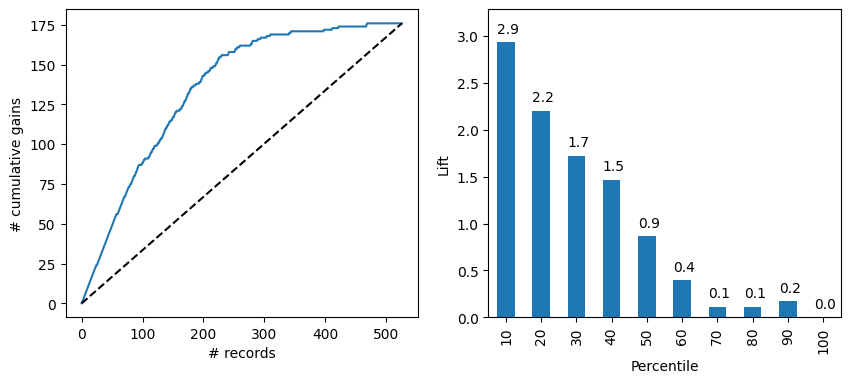

In [611]:
proba = knn15.predict_proba(test_X)
result = pd.DataFrame({'actual': test_y,
                       'p(0)': [p[0] for p in proba],
                       'p(1)': [p[1] for p in proba],
                       'predicted': knn15.predict(test_X) })
df = result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title=False)
plt.show()